In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [6]:
train_data = pd.read_csv("input/train.csv")
test_data = pd.read_csv("input/test.csv")

# Impute missing ages with median
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

C:\Users\clark\AppData\Local\Temp\ipykernel_25200\3181382583.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
C:\Users\clark\AppData\Local\Temp\ipykernel_25200\3181382583.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [7]:
def preprocess(df):
    df = df.copy()
    
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    def extract_title(x):
        try:
            title = x.split(' ')[1] if len(x.split(' ')) > 1 else 'Unknown'
        except IndexError:
            # if the expected format isn't found, return 'Uknown'
            return 'Unknown'
        
        if title in ['Mr', 'Mrs', 'Miss', 'Master']:
            return title
        elif title in ['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer']:
            return 'Rare'
        else:
            return 'Other'
    
    # Normalize name
    df["Name"] = df["Name"].apply(normalize_name)
    
    # Extract title
    df["Title"] = df["Name"].apply(extract_title)

    # Parse ticket number and ticket item
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    # df["Ticket_item"] = df["Ticket"].apply(ticket_item)

    # Add FamilySize feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Add IsAlone feature
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Cabin processing
    # Create a 'CabinType' feature
    df['HasCabin'] = (~df['Cabin'].isna()).astype(int)
    df['CabinLetter'] = df['Cabin'].fillna('U').apply(lambda x: x[0])
    df['CabinType'] = df['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else 'Unknown')
    # fill in NaN values in Cabin
    df['Cabin'] = df['Cabin'].fillna('Unknown')
       
    # Name length
    df['NameLength'] = df['Name'].apply(len)
    
    # Fare per person
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    
    # Is child
    df['IsChild'] = (df['Age'] < 12).astype(int)
    
    # Handle NaN values in Embarked
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Handle NaN values in Fare (which affects FarePerPerson)
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    # Recalculate FarePerPerson after handling NaN in Fare
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    
    # Handle any remaining NaN in FarePerPerson (in case of division by zero)
    df['FarePerPerson'] = df['FarePerPerson'].fillna(df['FarePerPerson'].median())
                         
    return df

preprocessed_train_df = preprocess(train_data)
preprocessed_serving_df = preprocess(test_data)

preprocessed_train_df.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Ticket_number,FamilySize,IsAlone,HasCabin,CabinLetter,CabinType,NameLength,FarePerPerson,IsChild
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,...,Mr,21171,2,0,0,U,Unknown,21,3.62500,0
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,...,Mrs,17599,2,0,1,C,C,47,35.64165,0
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,3101282,1,1,0,U,Unknown,20,7.92500,0
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,...,Mrs,113803,2,0,1,C,C,40,26.55000,0
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,...,Mr,373450,1,1,0,U,Unknown,22,8.05000,0


In [9]:
preprocessed_serving_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title,Ticket_number,FamilySize,IsAlone,HasCabin,CabinLetter,CabinType,NameLength,FarePerPerson,IsChild
0,892,3,Kelly Mr James,male,34.5,0,0,330911,7.8292,Unknown,...,Mr,330911,1,1,0,U,Unknown,14,7.829200,0
1,893,3,Wilkes Mrs James Ellen Needs,female,47.0,1,0,363272,7.0000,Unknown,...,Mrs,363272,2,0,0,U,Unknown,28,3.500000,0
2,894,2,Myles Mr Thomas Francis,male,62.0,0,0,240276,9.6875,Unknown,...,Mr,240276,1,1,0,U,Unknown,23,9.687500,0
3,895,3,Wirz Mr Albert,male,27.0,0,0,315154,8.6625,Unknown,...,Mr,315154,1,1,0,U,Unknown,14,8.662500,0
4,896,3,Hirvonen Mrs Alexander Helga E Lindqvist,female,22.0,1,1,3101298,12.2875,Unknown,...,Mrs,3101298,3,0,0,U,Unknown,40,4.095833,0


In [10]:
input_features = list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")
input_features.remove("Ticket_number")
# input_features.remove("Embarked")
# input_features.remove("FamilySize")
input_features.remove("FarePerPerson")

print(f"Input features: {input_features}")


Input features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'HasCabin', 'CabinLetter', 'CabinType', 'NameLength', 'IsChild']


In [11]:
# sklearn models
# select categorical features
categorical_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'HasCabin', 'IsChild', 'Title']
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson', 'NameLength']

# One-hot encode categorical variables
X = pd.get_dummies(preprocessed_train_df[categorical_features], drop_first=True)
X = pd.concat([X, preprocessed_train_df[numerical_features]], axis=1)

X_test = pd.get_dummies(preprocessed_serving_df[categorical_features], drop_first=True)
X_test = pd.concat([X_test, preprocessed_serving_df[numerical_features]], axis=1)

# Ensure X and X_test have the same columns
X, X_test = X.align(X_test, join='outer', axis=1, fill_value=0)

y = preprocessed_train_df['Survived']

In [12]:
def check_nan(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    if nan_columns:
        print("Columns with NaN values:")
        for col in nan_columns:
            nan_count = df[col].isna().sum()
            print(f"{col}: {nan_count} NaN values")
    else:
        print("No NaN values found in the DataFrame")

# Use this function on your preprocessed DataFrames
print("Training data:")
check_nan(preprocessed_train_df)
print("\nTest data:")
check_nan(preprocessed_serving_df)

Training data:
No NaN values found in the DataFrame

Test data:
No NaN values found in the DataFrame


In [13]:
# hyperparameter tuning with sklearn
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.025, 0.05, 0.1, 0.15, 0.2]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
prediction_proba = best_model.predict_proba(X_test)[:, 1]

cv_scores = cross_val_score(best_model, X, y, cv=5)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Best parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}
Best cross-validation score: 0.8383842822170611
Cross-validation scores: [0.83798883 0.83146067 0.85393258 0.81460674 0.85393258]
Mean CV score: 0.8383842822170611


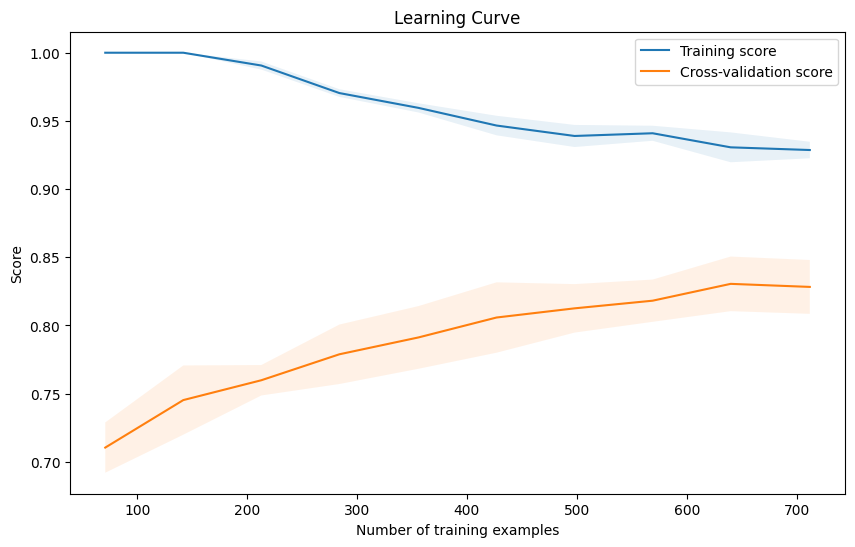

In [14]:
# Learning curves to diagnose bias-variance tradeoff
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

          feature  importance
6        Sex_male    0.306157
8        Title_Mr    0.153342
17  FarePerPerson    0.138685
0          Pclass    0.096598
16     FamilySize    0.058245
12            Age    0.057613
18     NameLength    0.052986
15           Fare    0.051637
1             Age    0.049404
4        HasCabin    0.020339
10    Title_Other    0.004551
11     Title_Rare    0.003540
9       Title_Mrs    0.002219
2           SibSp    0.001769
13          SibSp    0.001108
7      Title_Miss    0.000790
14          Parch    0.000471
5         IsChild    0.000307
3           Parch    0.000240


<Figure size 1000x600 with 0 Axes>

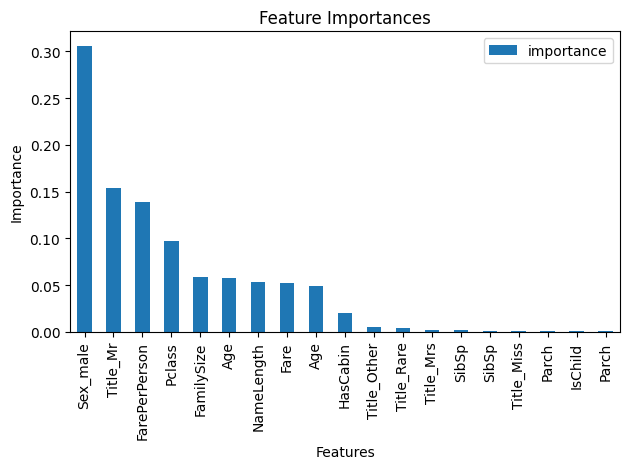

In [15]:
importances = best_model.feature_importances_
feature_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_imp = feature_imp.sort_values('importance', ascending=False)
print(feature_imp)

# Visualize feature importances
plt.figure(figsize=(10, 6))
feature_imp.plot(x='feature', y='importance', kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [81]:
# Create submission file
output = pd.DataFrame({'PassengerId': preprocessed_serving_df.PassengerId, 'Survived': (predictions > 0.5).astype(int)})
output.to_csv('output/submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


In [16]:
class_distribution = train_data['Survived'].value_counts(normalize=True)
print("Class distribution:\n", class_distribution)

Class distribution:
 Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [17]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [18]:
# advanced model optimization

# best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# retrain on best parameters
final_model = GradientBoostingClassifier(**best_params, random_state=42)
final_model.fit(X_resampled, y_resampled)

Best parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}


GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=200,
                           random_state=42)

In [19]:
# Create an ensemble
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(**best_params, random_state=42)

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('gb', gb)],
    voting='soft'
)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Fit the ensemble on the full resampled data
ensemble.fit(X_resampled, y_resampled)

# Make predictions on the test set
ensemble_predictions = ensemble.predict(X_test)
ensemble_proba = ensemble.predict_proba(X_test)[:, 1]

# Create submission file
output = pd.DataFrame({
    'PassengerId': preprocessed_serving_df.PassengerId, 
    'Survived': ensemble_predictions
})
output.to_csv('output/ensemble_submission.csv', index=False)
print("Ensemble submission file created successfully!")

c:\Users\clark\source\repos\Titanic\Titanic\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble submission file created successfully!
